In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
from numpy import exp, mod, meshgrid, cos, sin, exp, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Create MATRIX data

In [26]:
Nx, Nt, sigma = 100, 50, 1.0
coefficients1 = [-2,3] #[0,0,-3,5] #[-8,2]
coefficients2 = [3,1] #[0.03,0,0.8,-1.5]#[0,3,1]
seed = 42

In [27]:
Nx, Nt, sigma = 100, 50, 1.0
#coefficients1 = [0,0.5,-1,3] #[-8,2]
#coefficients2 = [0,3,1] #[7,1]
center_of_matrix1 = 20
center_of_matrix2 = 50 #200
#seed = 1

In [28]:
np.random.seed(seed)

In [29]:
def generate_data(Nx, Nt, coeff1,coeff2, center1, center2, sigma_slope=0.1, sigma_base=3.0):
    sigma = 5.0
    x = np.arange(0, Nx)
    t = np.linspace(-10,10, Nt)
    [X, T] = np.meshgrid(x, t)
    X = X.T
    T = T.T    

    def gaussian(x, mu, sigma=1.0):
        return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

    q1 = np.zeros_like(X, dtype=np.float64)
    q2 = np.zeros_like(X, dtype=np.float64)
    shift1 = np.polyval(coeff1, t)
    shift2 = np.polyval(coeff2, t)
    for col in range(Nt):
        sigma_t = sigma_base #+ sigma_slope * t[col]
        #sigma_t = max(sigma_t, 1e-8)
        for row in range(Nx):
            q1[row, col] = gaussian(row, center1 + shift1[col], sigma_t)
            q2[row, col] = gaussian(row, center2 + shift2[col], sigma_t)
    
    Q = np.maximum(q1, q2)
    Q /= Q.max()
    
    return Q, x, t

In [30]:
Q,x,t = generate_data(Nx, Nt, coefficients1, coefficients2, center_of_matrix2,center_of_matrix2)

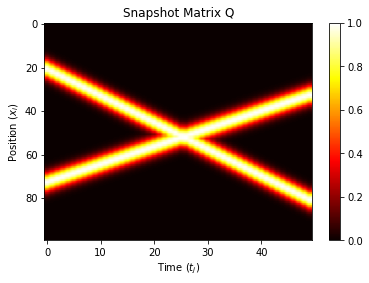

In [31]:
plt.imshow(Q, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [32]:
np.random.seed(seed)
torch.manual_seed(seed)

In [33]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = Q.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


# Define a model

In [34]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [37]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1[::-1]]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2[::-1]]
        )
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 64)
        self.f1_fc4 = nn.Linear(64, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 64)
        self.f2_fc4 = nn.Linear(64, 1)

        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = sum([coeff * t**i for i, coeff in enumerate(self.alphas1)])

        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.alphas2)])

        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift

In [38]:
init_coefficients1 = [-1,1]
init_coefficients2 = [1,1]

In [39]:
model = ShapeShiftNet(init_coefficients1, init_coefficients2)

torch.manual_seed(seed)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
Q_tensor = torch.tensor(Q)

In [41]:
D = torch.zeros((Nx-1, Nx))
for i in range(Nx-1):
    D[i, i] = -1
    D[i, i+1] = 1

In [42]:
num_epochs = 30_000
lambda_k = 0.5
lambda_tv = 0.01

for epoch in range(num_epochs + 1):
    x, t = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    optimizer.zero_grad()
    f1_full, f2_full, shift1_pred, shift2_pred, f1_full_nos, f2_full_nos = model(x,t)
    
    frobenius_loss = torch.norm(Q_tensor - f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt), 'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt))
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k*(nuclear_loss_q1 + nuclear_loss_q2)
    
    #finite_diff_result = D@f1_full_nos.view(Nx, Nt) + D@f2_full_nos.view(Nx, Nt)
    #TV = lambda_tv*torch.norm(finite_diff_result, 'fro')**2
    
    total_loss = frobenius_loss + nuclear_loss #+ TV

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    shift_coeffs1 = torch.tensor([p.item() for p in model.alphas1])
    shift_coeffs2 = torch.tensor([p.item() for p in model.alphas2])
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},'
            f'Coefficients_1:{[coefficients2[::-1][i] for i in range(len(coefficients2))]}{-shift_coeffs1}, Coefficients_2:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{-shift_coeffs2}')

Epoch 0/30000, Frob Loss: 13153.383200600805, Nuclear Loss: 155.5697021484375, Total loss: 13308.952902749243,Coefficients_1:[1, 3]tensor([-1.0010,  0.9990]), Coefficients_2:[3, -2]tensor([-0.9990, -0.9990])
Epoch 100/30000, Frob Loss: 345.26580698309164, Nuclear Loss: 60.96983337402344, Total loss: 406.2356403571151,Coefficients_1:[1, 3]tensor([-0.9940,  0.9866]), Coefficients_2:[3, -2]tensor([-0.9967, -0.9862])
Epoch 200/30000, Frob Loss: 319.1707687829877, Nuclear Loss: 10.333009719848633, Total loss: 329.5037785028363,Coefficients_1:[1, 3]tensor([-0.9929,  0.9872]), Coefficients_2:[3, -2]tensor([-0.9960, -0.9872])
Epoch 300/30000, Frob Loss: 299.8301935019876, Nuclear Loss: 10.75374698638916, Total loss: 310.58394048837675,Coefficients_1:[1, 3]tensor([-0.9918,  0.9878]), Coefficients_2:[3, -2]tensor([-0.9953, -0.9876])
Epoch 400/30000, Frob Loss: 279.99445976071274, Nuclear Loss: 12.029653549194336, Total loss: 292.0241133099071,Coefficients_1:[1, 3]tensor([-0.9905,  0.9888]), Coef

KeyboardInterrupt: 

In [43]:
combined = f1_full + f2_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

Text(0.5, 1.0, '$\\mathbf{Q}^2$')

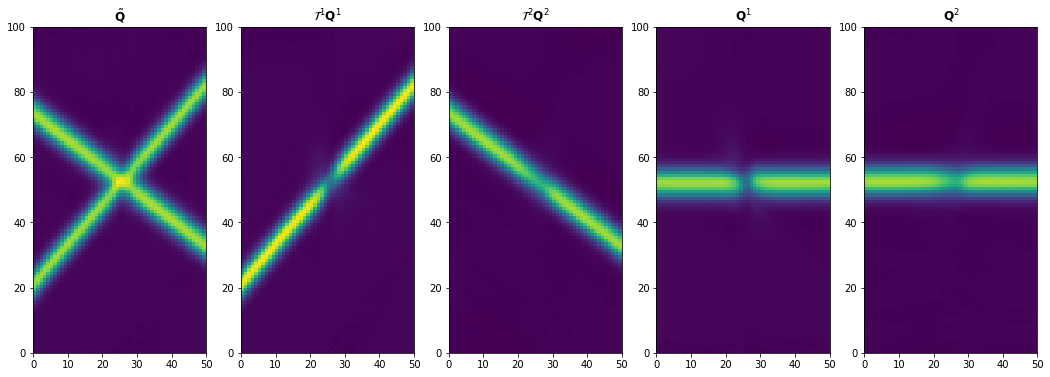

In [44]:
# with TV lambda=0.01
#0.01

fig, axs = plt.subplots(1, 5, figsize=(18, 6))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].pcolor(Q_tilde, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\tilde{\mathbf{Q}}$")
#axs[0].set_xlabel('$t_j$)')
#axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].pcolor(f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin)
axs[1].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
#axs[1].set_xlabel('Time ($t_j$)')
#axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].pcolor(f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
#axs[2].set_xlabel('Time ($t_j$)')
#axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].pcolor(f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathbf{Q}^1$")
#axs[3].set_xlabel('Time ($t_j$)')
#axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].pcolor(f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^2$")
#axs[4].set_xlabel('Time ($t_j$)')
#axs[4].set_ylabel('Position ($x_i$)')

In [38]:
torch.save(model.state_dict(), 'model_weights.pth')